<a href="https://colab.research.google.com/github/prabhsuratsingh/iris-pytorch-nn/blob/master/pytorch_iris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install torch torchvision scikit-learn numpy

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
X = iris['data']
y = iris['target']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1./3, random_state=1
)

In [4]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
X_train_norm = torch.from_numpy(X_train_norm).float()
y_train = torch.from_numpy(y_train)

train_ds = TensorDataset(X_train_norm, y_train)
torch.manual_seed(1)
batch_size = 2
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [5]:
from torch import nn

class Model(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.layer1 = nn.Linear(input_size, hidden_size)
    self.layer2 = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    x = self.layer1(x)
    x = nn.Sigmoid()(x)
    x = self.layer2(x)
    return x

input_size = X_train_norm.shape[1]
hidden_size = 16
output_size = 3
model = Model(input_size, hidden_size, output_size)

In [7]:
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [9]:
num_epochs = 100
loss_hist = [0]*num_epochs
accuracy_hist = [0] * num_epochs
for epoch in range(num_epochs):
  for x_batch, y_batch in train_dl:
    pred = model(x_batch)
    loss = loss_fn(pred, y_batch)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_hist[epoch] += loss.item()*y_batch.size(0)
    is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
    accuracy_hist[epoch] += is_correct.sum()
  loss_hist[epoch] /= len(train_dl.dataset)
  accuracy_hist[epoch] /= len(train_dl.dataset)

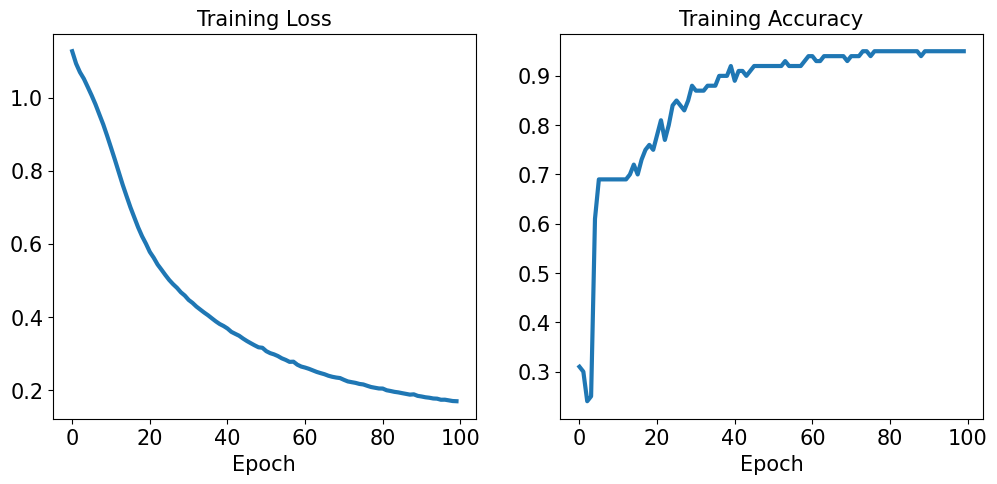

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1,2,1)
ax.plot(loss_hist, lw=3)
ax.set_title('Training Loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1,2,2)
ax.plot(accuracy_hist, lw=3)
ax.set_title('Training Accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)


plt.show()

In [12]:
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm).float()
y_test = torch.from_numpy(y_test)

pred_test = model(X_test_norm)
correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()
print(f"Test Accuracy : {accuracy:.4f}")

Test Accuracy : 0.9800


In [13]:
path = 'iris_classifier.pt'
torch.save(model, path)

In [18]:
torch.serialization.add_safe_globals([Model])
model_new = torch.load(path, weights_only=False)

In [19]:
model_new.eval()

Model(
  (layer1): Linear(in_features=4, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=3, bias=True)
)